# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
IMG_SIZE_VGG16 = (224, 224)  # размер входного изображения сети
IMG_SIZE_IV3 = (299, 299)  # размер входного изображения сети
IMG_SIZE_IRNV2 = (299, 299)  # размер входного изображения сети
IMG_SIZE_MNV2 = (224, 224)  # размер входного изображения сети


## Функции загрузки данных

In [4]:
import re
from random import shuffle
from glob import glob
import random

train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')


dict_models = {}

dict_aug = [
    {},
    {'flip_horizontal':True, },
    {'flip_horizontal':True, 'theta':-5},
    {'flip_horizontal':True, 'theta':5},
    {'theta':-5},
    {'theta':5},
]


aug_data_gen = ImageDataGenerator()

## Визуализируем примеры для обучения

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    print(path,re.match('.*dog\.\d', path))
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path);

## VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
# загружаем входное изображение и предобрабатываем
def load_image(path):
    img = load_img(path, target_size=IMG_SIZE_VGG16)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16
# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([aug_data_gen.apply_transform(load_image(path), dict_aug[random.randint(0,5)]) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])                      

In [ ]:
base_model = VGG16(include_top = False,weights = 'imagenet',input_shape = ((IMG_SIZE_VGG16[0], IMG_SIZE_VGG16[1], 3)))
for layer in base_model.layers[:-1]:
    layer.trainable = False
x = base_model.layers[-5].output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x) # kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)
#dict_models['VGG16'] = model

In [ ]:
model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
                  metrics=['accuracy'])
shuffle(train_files)  # перемешиваем обучающую выборку
train_val_split = 250  # число изображений в валидационной выборке
validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))
   # запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:], train_val_split),                    
           steps_per_epoch=20, epochs=50, validation_data=validation_data)
model.save('cats-dogs-VGG16.hdf5')
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

with open('submit_vgg16.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

## InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_IV3
# загружаем входное изображение и предобрабатываем
def load_image(path):
    img = load_img(path, target_size=IMG_SIZE_IV3)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для MobileNetV2
# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([aug_data_gen.apply_transform(load_image(path), dict_aug[random.randint(0,5)]) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])           


inc_model=InceptionV3(include_top=False, weights='imagenet', input_shape=((IMG_SIZE_IV3[0], IMG_SIZE_IV3[1],3)))
for layer in inc_model.layers:
    layer.trainable = False
x = inc_model.layers[-1].output    
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-4))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-4))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x) # kernel_regularizer=keras.regularizers.l1(1e-4))(x)

model = Model(inputs=inc_model.input, outputs=x)
model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
                  metrics=['accuracy'])
shuffle(train_files)  # перемешиваем обучающую выборку
train_val_split = 250  # число изображений в валидационной выборке
validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))
   # запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:], train_val_split),                    
           steps_per_epoch=20, epochs=100, validation_data=validation_data)
model.save('cats-dogs-IV3.hdf5')
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

with open('submit_IV3.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))



## InceptionResNetV2

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input 
# загружаем входное изображение и предобрабатываем
def load_image(path):
    img = load_img(path, target_size=IMG_SIZE_IRNV2)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для MobileNetV2
# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([aug_data_gen.apply_transform(load_image(path), dict_aug[random.randint(0,5)]) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])           




res_model=InceptionResNetV2(include_top=False, weights='imagenet', input_shape=((IMG_SIZE_IRNV2[0], IMG_SIZE_IRNV2[1],3)))
for layer in res_model.layers:
    layer.trainable = False
x = res_model.layers[-1].output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
#x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-4))(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x) # kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=res_model.input, outputs=x)

model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
                  metrics=['accuracy'])
shuffle(train_files)  # перемешиваем обучающую выборку
train_val_split = 250  # число изображений в валидационной выборке
validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))
   # запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:], train_val_split),                    
           steps_per_epoch=20, epochs=100, validation_data=validation_data)
model.save('cats-dogs-IRNV2.hdf5')
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

with open('submit_IRNV2.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [ ]:
!cat submit_IRNV2.txt

## MobileNetV2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# загружаем входное изображение и предобрабатываем
def load_image(path):
    img = load_img(path, target_size=IMG_SIZE_MNV2)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для MobileNetV2
# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([aug_data_gen.apply_transform(load_image(path), dict_aug[random.randint(0,5)]) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])           

mnet_model=MobileNetV2(include_top=False, weights='imagenet', input_shape=((IMG_SIZE_MNV2[0], IMG_SIZE_MNV2[1],3)))
for layer in mnet_model.layers:
    layer.trainable = False
x = mnet_model.layers[-1].output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-6))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-6))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x) # kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=mnet_model.input, outputs=x)
#dict_models['MNV2'] = model
model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
                  metrics=['accuracy'])
shuffle(train_files)  # перемешиваем обучающую выборку
train_val_split = 250  # число изображений в валидационной выборке
validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))
   # запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:], train_val_split),                    
           steps_per_epoch=20, epochs=100, validation_data=validation_data)
model.save('cats-dogs-MNV2.hdf5')
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

with open('submit_MNV2.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [ ]:
!cat submit_MNV2.txt


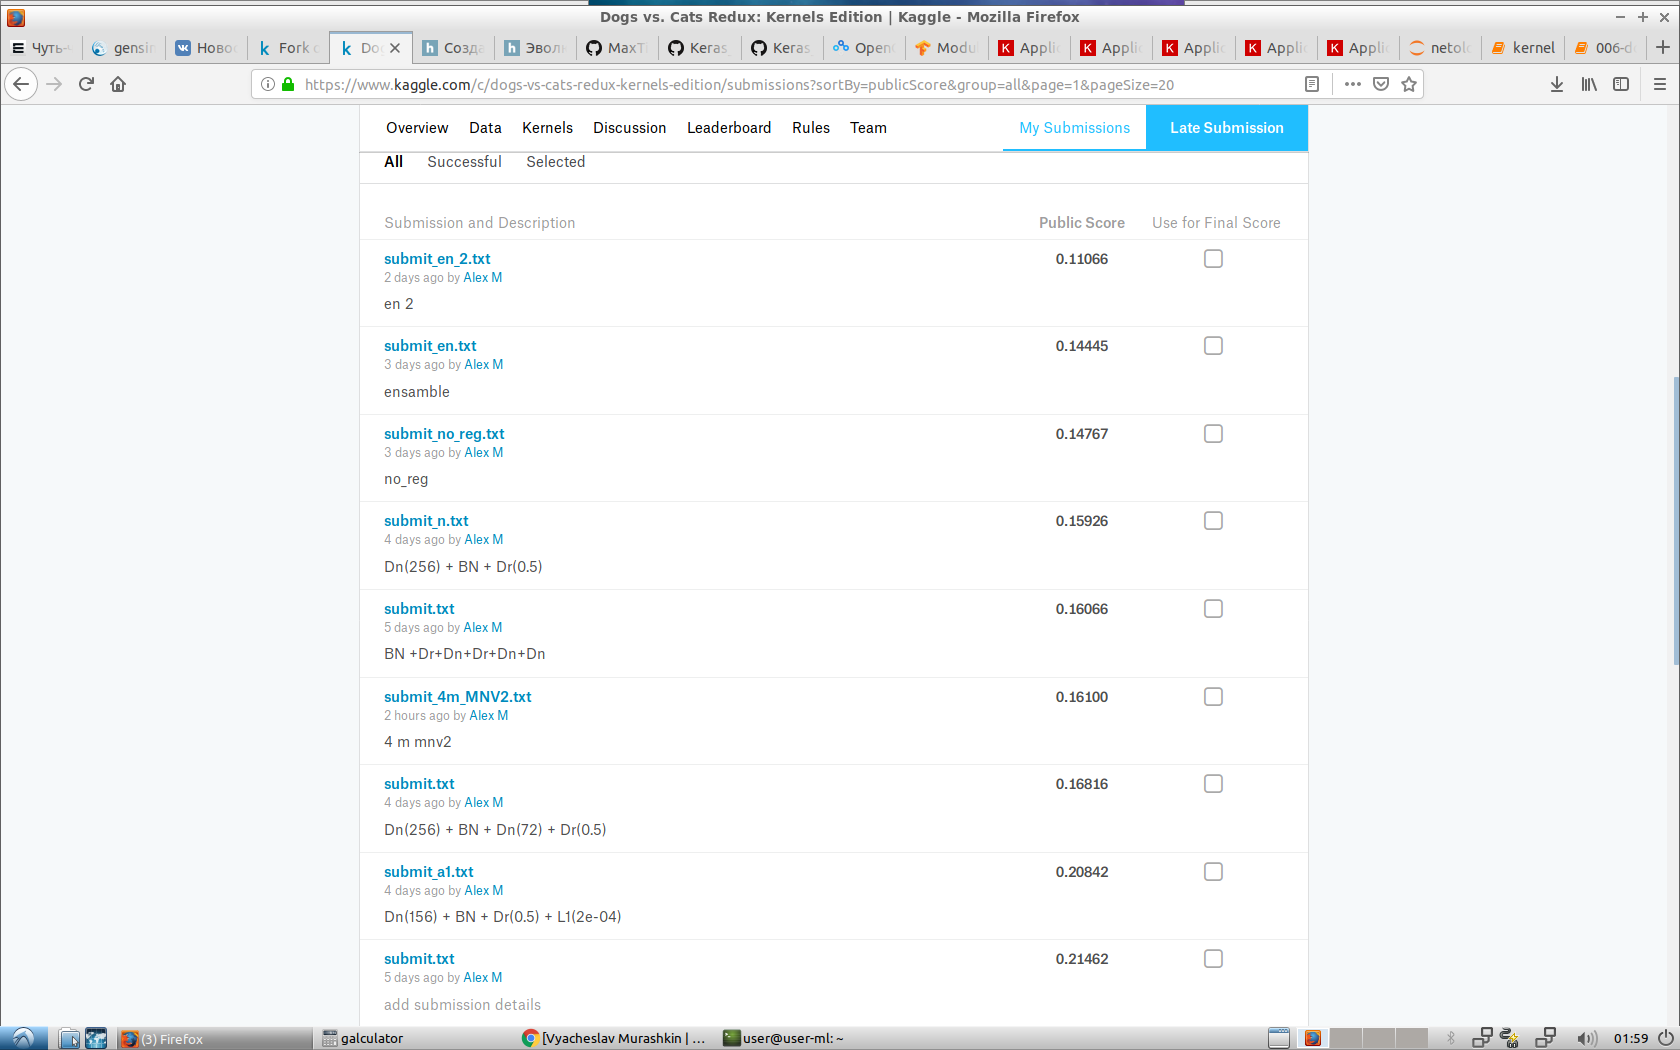

In [1]:
from IPython.display import Image
Image("all-commit.png")

In [ ]:
# попробуем ансамблирование 
# при отборе результата будем отбрасывать самое дальний результат от среднего и считать новое среднее